In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install albumentations==0.4.6
!pip install pycocotools
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 KB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65173 sha256=e26bb3e48c3b922006772ca7e632362f2c2499a87852fdc7498b546d61fc841c
  Stored in directory: /root/.cache/pip/wheels/d2/e3/0b/99a239413035502833a7b07283894243fddf5ce3aa720ca8dd
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/Skola/py-AI/wildfire/test_obj')

In [4]:
%%shell

git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 292983, done.
remote: Counting objects: 100% (2775/2775), done.
remote: Compressing objects: 100% (176/176), done.
remote: Total 292983 (delta 2608), reused 2738 (delta 2593), pack-reused 290208
Receiving objects: 100% (292983/292983), 586.77 MiB | 12.64 MiB/s, done.
Resolving deltas: 100% (268559/268559), done.
Note: switching to 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 2f40a483d7 [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [5]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torchvision.transforms as transform
import albumentations as A
import torchvision
import torch
import cv2

from torchvision.models.detection.rpn import AnchorGenerator
from albumentations.pytorch.transforms import ToTensorV2
from torchvision.models.detection import FasterRCNN
from engine import train_one_epoch, evaluate
from torch.utils.data import Dataset, DataLoader
from typing import Any

In [6]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [7]:
train_df = pd.read_csv('/content/drive/MyDrive/Skola/py-AI/wildfire/test_obj/train_annotations.csv')
valid_df = pd.read_csv('/content/drive/MyDrive/Skola/py-AI/wildfire/test_obj/valid_annotations.csv')

train_images = '/content/drive/MyDrive/Skola/py-AI/wildfire/test_obj/train'
valid_images = '/content/drive/MyDrive/Skola/py-AI/wildfire/test_obj/valid'

train_df.tail()

,filename,width,height,class,xmin,ymin,xmax,ymax
1200,fire-9.jpg,640,480,fire,65,306,208,355
1201,fire-9.jpg,640,480,fire,1,350,89,377
1202,fire-9.jpg,640,480,fire,496,363,527,386
1203,fire-9.jpg,640,480,fire,459,342,486,371
1204,fire-9.jpg,640,480,fire,612,332,640,353


In [8]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

LABELS = train_df['class'].unique()
NUM_OF_CLASSES = len(LABELS)+1
IN_FEATURES = model.roi_heads.box_predictor.cls_score.in_features

SAVE_PATH = '/content/drive/MyDrive/Skola/py-AI/wildfire/test_obj/models/'
MODEL_NAME = 'model_new.pt'

In [9]:
def collate_fn(batch: tuple) -> tuple:
  return tuple(zip(*batch))

def train(model, train_loader, valid_loader, epochs) -> None:
  params = [param for param in model.parameters() if param.requires_grad]
  optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)  # TODO: Optimize params

  lr_schedule = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)  # TODO: Optimize params

  for epoch in range(epochs):
    train_one_epoch(
        model=model,
        optimizer=optimizer,
        data_loader=train_loader,
        device=DEVICE,
        epoch=epoch,
        print_freq=len(train_loader)
    )
    
    lr_schedule.step()
    evaluate(
        model=model,
        data_loader=valid_loader,
        device=DEVICE
    )

In [10]:
def plot_images(images, targets) -> None:
  max_images = 4
  img_counter = 0

  for image, target in zip(images, targets):
    if img_counter == max_images:
      break

    img_counter += 1

    sample = image.permute(1,2,0).cpu().numpy()
    boxes = target['boxes'].cpu().numpy().astype(np.int32)
    labels = target['labels'].cpu().numpy()

    fig, ax = plt.subplots(1, 1, figsize=(10,8))

    for i, box in enumerate(boxes):
      cv2.rectangle(
          img=sample,
          pt1=(box[0], box[1]),
          pt2=(box[2], box[3]),
          color=(1,0,0),
          thickness=1
      )
      cv2.putText(
          img=sample,
          text=LABELS[(labels[i]-1)],
          org=(box[0], box[1]-10),
          fontFace=cv2.FONT_HERSHEY_DUPLEX,
          fontScale=0.3,
          color=(0,0,0),
          thickness=1
      )
    
    ax.set_axis_off();
    ax.imshow((sample * 255).astype(np.uint8))

In [11]:
class LabelMap:
  def __init__(self, labels: list) -> None:
    self._map = {c: i+1 for i, c in enumerate(labels)}
    self.reversed_map = {i: c for i, c in enumerate(labels)}

  def fit(self, df: pd.DataFrame, col: str) -> pd.DataFrame:
    df[col] = df[col].map(self._map)
    return df

In [12]:
class WildfireDataset(Dataset):
  def __init__(self, df: pd.DataFrame, img_path: str, labels: list, transforms: Any = None, **kwargs) -> None:
    super().__init__(**kwargs)
    self.df = df
    self.img_path = img_path
    self.labels = labels
    self.images = self.df['filename'].unique()
    self.transforms = transforms

  def __len__(self) -> int:
    return len(self.images)

  def __getitem__(self, i: int) -> tuple:
    img_file = os.path.join(self.img_path, self.images[i])

    img = cv2.imread(img_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)
    img = img/255.0

    img_data = self.df.loc[self.df['filename'] == self.images[i]]

    xmins = img_data['xmin'].values
    ymins = img_data['ymin'].values
    xmaxs = img_data['xmax'].values
    ymaxs = img_data['ymax'].values

    boxes = torch.as_tensor(np.stack([xmins, ymins, xmaxs, ymaxs], axis=1), dtype=torch.float32)
    labels = torch.as_tensor(img_data['class'].values, dtype=torch.int64)
    _id = torch.tensor([i])

    areas = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])
    areas = torch.as_tensor(areas, dtype=torch.float32)

    iscrowd = torch.zeros((len(labels),), dtype=torch.int64)

    target = dict()
    target['boxes'] = boxes
    target['labels'] = labels
    target['image_id'] = _id
    target['area'] = areas
    target['iscrowd'] = iscrowd

    if self.transforms:
      transformed = self.transforms(image=img, bboxes=boxes, labels=labels)
      img = transformed['image']
      target['boxes'] = torch.as_tensor(transformed['bboxes'], dtype=torch.float32)
    
    return torch.as_tensor(img, dtype=torch.float32), target

  def get_h_w(self, image: str) -> tuple:
    """Get height and width of image"""
    img_data = self.df.loc[self.df['filename'] == image]
    return img_data['width'].values[0], img_data['height'].values[0]

In [13]:
label_map = LabelMap(LABELS)  # 1='smoke', 2='fire'

train_df = label_map.fit(train_df, 'class')
valid_df = label_map.fit(valid_df, 'class')

train_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,ck0qd8gs6ko7j0721x25cv4o3_jpeg.rf.005f5707706e...,640,480,1,125,190,177,286
1,ck0t40rhdz68s0a46ekx049a6_jpeg.rf.00403179fe5f...,640,480,1,326,207,494,249
2,ck0m0ch9ugnna07940o8x989j_jpeg.rf.0101cdb46a16...,640,480,1,308,166,582,257
3,ck0rr6bfa9b3w0721aw5unwdy_jpeg.rf.00982c053d66...,640,480,1,241,204,310,244
4,ck0uk75x5ysls0721e5a9j891_jpeg.rf.00d7fd8503e1...,640,480,1,523,208,619,288


In [14]:
# TODO: Optimize params
train_transform = A.Compose(
    [
      A.HorizontalFlip(p=0.5),
      A.RandomBrightnessContrast(p=0.2),
      ToTensorV2(p=1)
    ],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])
)
valid_transform = A.Compose(
    [ToTensorV2(p=1)],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])
)

In [15]:
train_dataset = WildfireDataset(train_df, train_images, LABELS, train_transform)
valid_dataset = WildfireDataset(valid_df, valid_images, LABELS, valid_transform)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

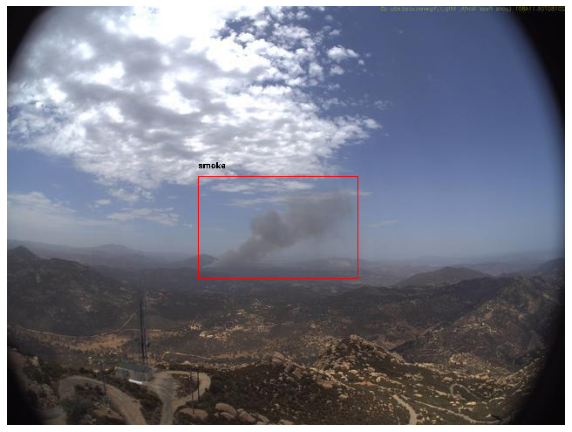

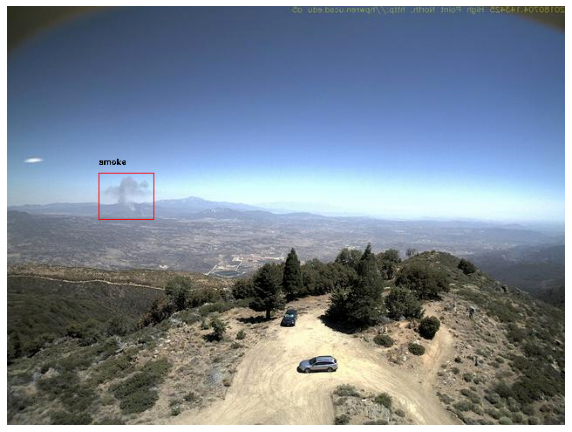

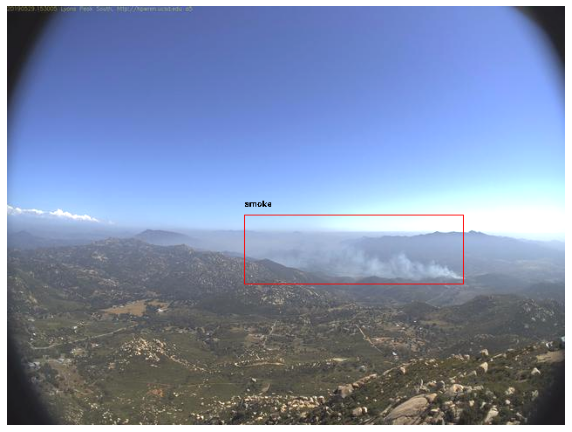

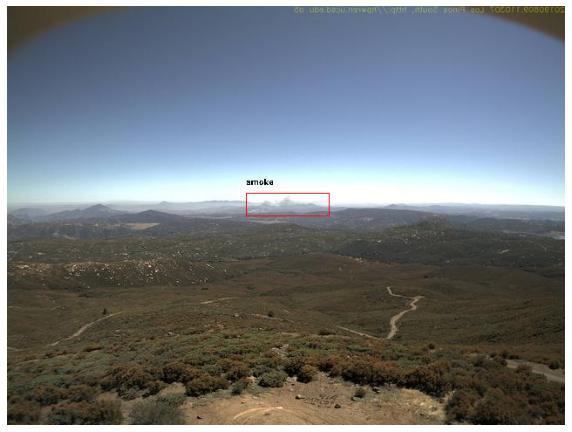

In [16]:
images, targets = next(iter(train_dataloader))
plot_images(images, targets)

In [17]:
targets[1]['labels']

tensor([1])

In [18]:
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(IN_FEATURES, NUM_OF_CLASSES)
model = model.to(DEVICE) 

In [19]:
train(model, train_dataloader, valid_dataloader, epochs=20)

KeyboardInterrupt: ignored

In [ ]:
torch.save(model.state_dict(), SAVE_PATH + MODEL_NAME)